# The Case against Overflow

We're against the inclusion of the overflow testcase in the suite presented for the analysis of spurious mixing in models, for a few reasons:

- The slope is very steep, so the model has a very hard time actually resolving a current down the slope
- The flow can hit the end wall during the simulation, which affects the results
- The choice of averaging window for RPE change doesn't appear to include any slope flow, but does include end effects

In [22]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import lib
from netCDF4 import Dataset

In [27]:
# globally increase figure size
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

In [37]:
nu_h = ['0.01', '0.1', '1', '10', '100', '1000']
# static list of grid Reynolds numbers (using theoretical front velocity)
gridRe = 1.57 * 1e3 / np.array(list(map(float, nu_h)))

# Petersen Setup

Let's first take a look at the normalised RPE evolution. PLM is plotted with solid lines, PPM in dashed. Curiously, at some values of KH the magnitude of RPE is higher when using PPM!

In [17]:
rpe_p = [lib.rpe_norm('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_KH{}/prog.nc'.format(nu),
                      step=1) for nu in nu_h]
rpe_pp = [lib.rpe_norm('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_PPM_KH{}/prog.nc'.format(nu),
                      step=1) for nu in nu_h]

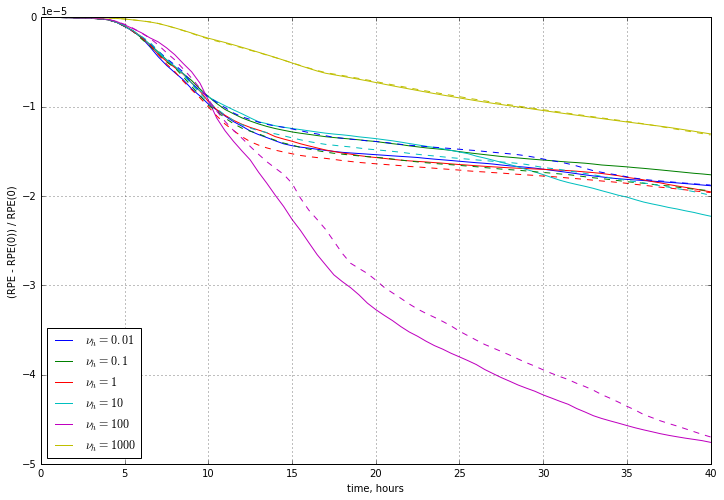

In [18]:
for nu, (t, r) in zip(nu_h, rpe_p):
    plt.plot(t, r, label=r'$\nu_h = {}$'.format(nu))
    
plt.gca().set_prop_cycle(None)
for t, r in rpe_pp:
    plt.plot(t, r, '--')
    
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.legend(loc='lower left')
plt.xlabel('time, hours')
plt.ylabel('(RPE - RPE(0)) / RPE(0)')

In [52]:
drpe_p = np.array([lib.drpe_dt('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_KH{}/prog.nc'.format(nu))
                   for nu in nu_h])
drpe_pp = np.array([lib.drpe_dt('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_PPM_KH{}/prog.nc'.format(nu))
                   for nu in nu_h])

drpe_p_mean = np.mean(drpe_p[:,25:74], axis=1)
drpe_pp_mean = np.mean(drpe_pp[:,25:74], axis=1)

## dRPE/dt

Now we can look at the mean rate of change of RPE for each case. This plot is a little hard to decipher. The green points are using PLM, and magenta are PPM. Circles use the mean of dRPE/dt from 13-37 hours (discussed below), and triangles are from 0-13 hours (hopefully just capturing overflow dynamics). There's no consistent advantage to PPM over PLM here.

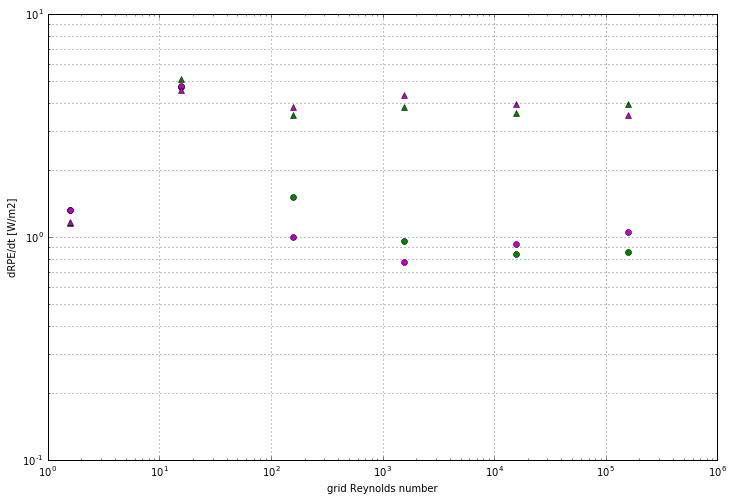

In [55]:
plt.loglog(gridRe, drpe_p_mean, 'go')
plt.loglog(gridRe, drpe_pp_mean, 'mo')
plt.loglog(gridRe, drpe_p[:,:25].mean(axis=1), 'g^')
plt.loglog(gridRe, drpe_pp[:,:25].mean(axis=1), 'm^')
plt.xlabel('grid Reynolds number')
plt.ylabel('dRPE/dt [W/m2]')
plt.grid(which='both', axis='y')
plt.grid(axis='x')

## Snapshots

Now let's take a look at some snapshots of the model state during the simulation. First we'll look at the snapshots taken at 3 hours and 6 hours, which show the actual progression of the overflow. We're looking at PLM on the top row, PPM on the bottom -- the differences seem minimal.

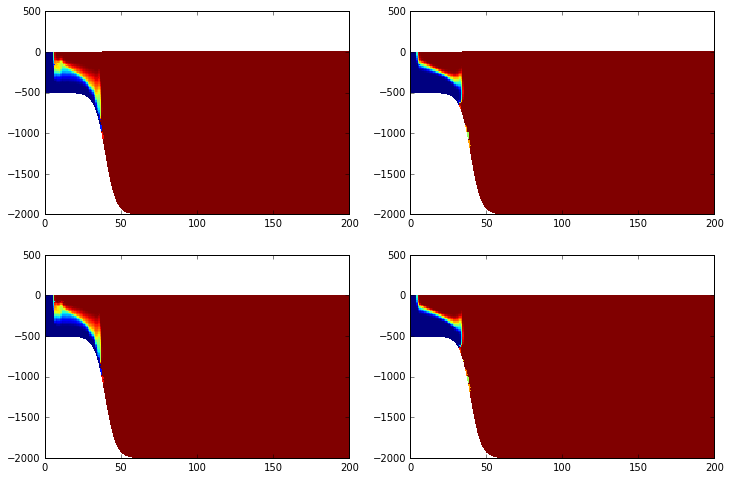

In [28]:
t = 5 # 3-hour snapshot

for i, e in enumerate(['KH0.01', 'KH1000', 'PPM_KH0.01', 'PPM_KH1000']):
    d = Dataset('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_{}/prog.nc'.format(e), 'r')
    x = d.variables['xh'][:]
    y = d.variables['e'][t, ...].mean(axis=1)
    z = d.variables['T_postale'][t, ...].mean(axis=1)
    d.close()
    
    plt.subplot(2, 2, i+1)
    plt.pcolor(x, y, z)

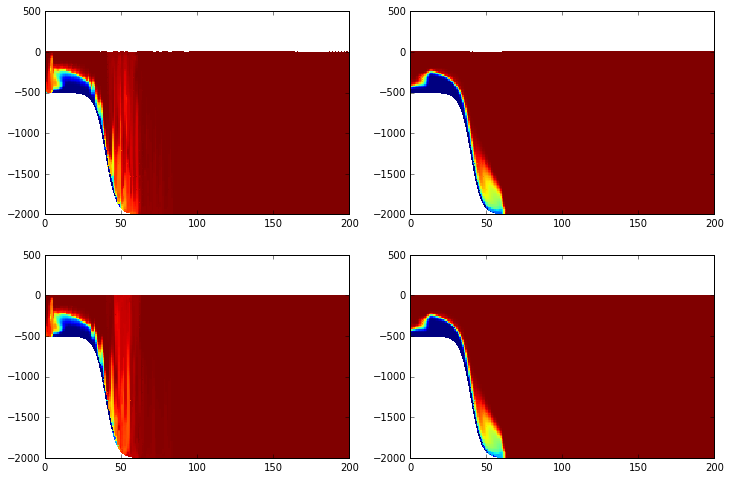

In [29]:
t = 11 # 6-hour snapshot

for i, e in enumerate(['KH0.01', 'KH1000', 'PPM_KH0.01', 'PPM_KH1000']):
    d = Dataset('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_{}/prog.nc'.format(e), 'r')
    x = d.variables['xh'][:]
    y = d.variables['e'][t, ...].mean(axis=1)
    z = d.variables['T_postale'][t, ...].mean(axis=1)
    d.close()
    
    plt.subplot(2, 2, i+1)
    plt.pcolor(x, y, z)

Now let's look at the 13 hour snapshot, which is when the averaging for the RPE calculation starts. It appears as though most of the overflow has diffused away, and the actual dynamics have been completely missed!

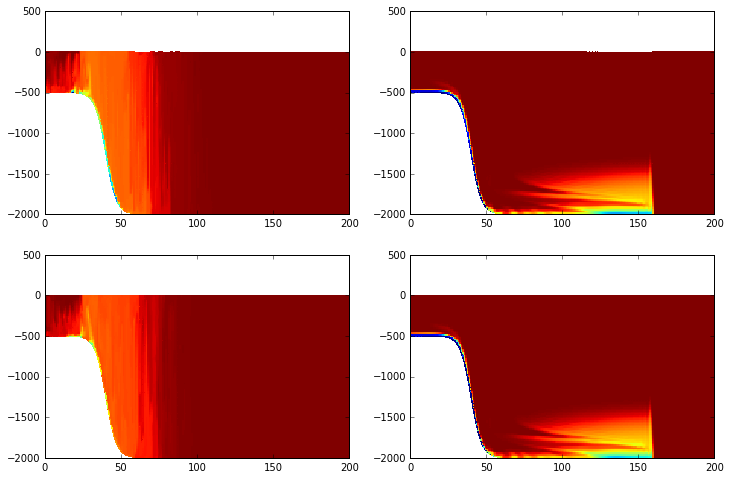

In [34]:
t = 25 # 13-hour snapshot

for i, e in enumerate(['KH0.01', 'KH1000', 'PPM_KH0.01', 'PPM_KH1000']):
    d = Dataset('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_{}/prog.nc'.format(e), 'r')
    x = d.variables['xh'][:]
    y = d.variables['e'][t, ...].mean(axis=1)
    z = d.variables['T_postale'][t, ...].mean(axis=1)
    d.close()
    
    plt.subplot(2, 2, i+1)
    plt.pcolor(x, y, z)

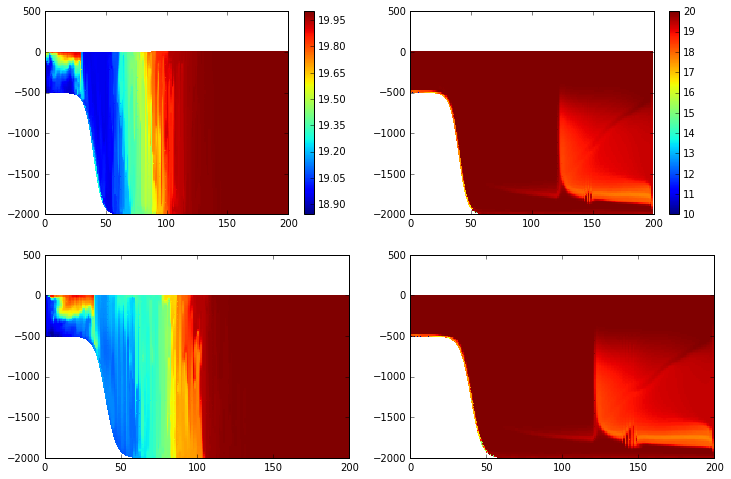

In [51]:
t = 74 # 37-hour snapshot

for i, e in enumerate(['KH0.01', 'KH1000', 'PPM_KH0.01', 'PPM_KH1000']):
    d = Dataset('/scratch/mizuchi1/angus/spurious/flow_downslope/flow_downslope_{}/prog.nc'.format(e), 'r')
    x = d.variables['xh'][:]
    y = d.variables['e'][t, ...].mean(axis=1)
    z = d.variables['T_postale'][t, ...].mean(axis=1)
    d.close()
    
    plt.subplot(2, 2, i+1)
    plt.pcolor(x, y, z)
    
    if i < 2: plt.colorbar()

# MOM6 Setup

The MOM6 setup uses a longer domain (4x longer), twice as deep, but at somewhat coarser resolution (10x horizontal, 5x vertical). I've slightly modified it so that the overflow is into an unstratified ambient with the same density difference as the case above.

In [13]:
rpe_m = [lib.rpe_norm('/scratch/mizuchi1/angus/expts/flow_downslope/z_KH{}/prog.nc'.format(nu),
                      step=1, split=False) for nu in nu_h]
rpe_mp = [lib.rpe_norm('/scratch/mizuchi1/angus/expts/flow_downslope/z_KH{}_PPM/prog.nc'.format(nu),
                      step=1, split=False) for nu in nu_h]

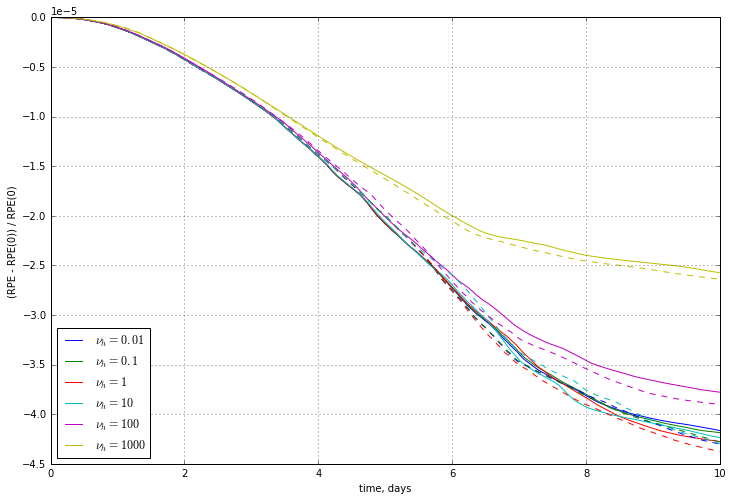

In [14]:
for nu, (t, r) in zip(nu_h, rpe_m):
    plt.plot(t, r, label=r'$\nu_h = {}$'.format(nu))
    
plt.gca().set_prop_cycle(None)

for t, r in rpe_mp:
    plt.plot(t, r, '--')
    
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.legend(loc='lower left')
plt.xlabel('time, days')
plt.ylabel('(RPE - RPE(0)) / RPE(0)')

In [41]:
drpe_m = np.array([lib.drpe_dt('/scratch/mizuchi1/angus/expts/flow_downslope/z_KH{}/prog.nc'.format(nu), split=False)
                 for nu in nu_h])
drpe_mp = np.array([lib.drpe_dt('/scratch/mizuchi1/angus/expts/flow_downslope/z_KH{}_PPM/prog.nc'.format(nu), split=False)
                 for nu in nu_h])

drpe_m = np.mean(drpe_m, axis=1)
drpe_mp = np.mean(drpe_mp, axis=1)

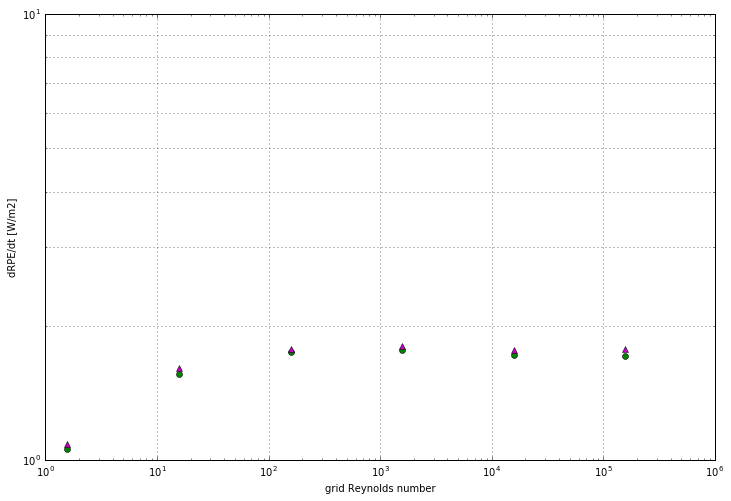

In [42]:
plt.loglog(gridRe, drpe_m, 'go')
plt.loglog(gridRe, drpe_mp, 'm^')
plt.xlabel('grid Reynolds number')
plt.ylabel('dRPE/dt [W/m2]')
plt.grid(which='both', axis='y')
plt.grid(axis='x')

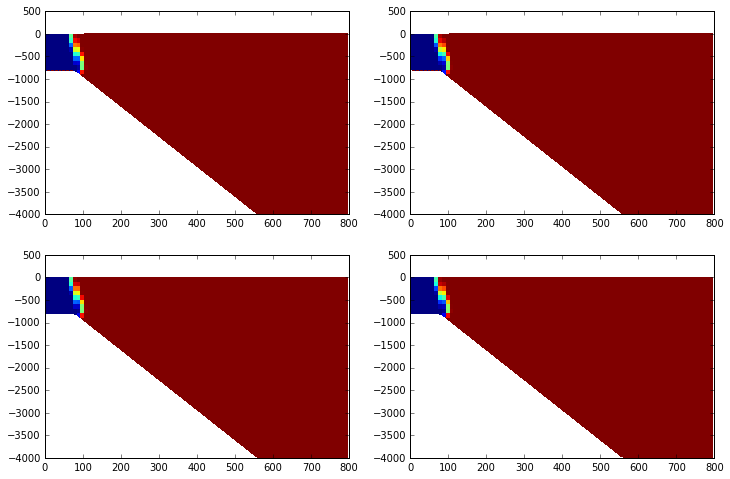

In [47]:
t = 2 # 3-hour snapshot

for i, e in enumerate(['KH0.01', 'KH1000', 'KH0.01_PPM', 'KH1000_PPM']):
    d = Dataset('/scratch/mizuchi1/angus/expts/flow_downslope/z_{}/prog.nc'.format(e), 'r')
    x = d.variables['xh'][:]
    y = d.variables['e'][t, ...].mean(axis=1)
    z = d.variables['temp'][t, ...].mean(axis=1)
    d.close()
    
    plt.subplot(2, 2, i+1)
    plt.pcolor(x, y, z)

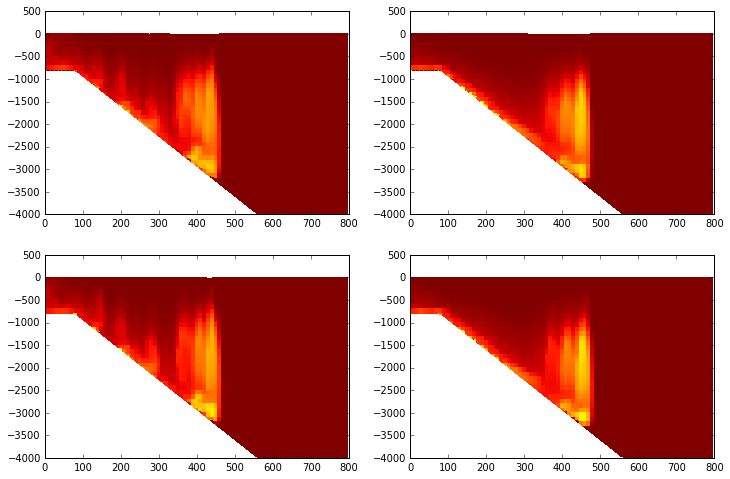

In [46]:
t = 72 # 3-day snapshot

for i, e in enumerate(['KH0.01', 'KH1000', 'KH0.01_PPM', 'KH1000_PPM']):
    d = Dataset('/scratch/mizuchi1/angus/expts/flow_downslope/z_{}/prog.nc'.format(e), 'r')
    x = d.variables['xh'][:]
    y = d.variables['e'][t, ...].mean(axis=1)
    z = d.variables['temp'][t, ...].mean(axis=1)
    d.close()
    
    plt.subplot(2, 2, i+1)
    plt.pcolor(x, y, z)